## Начало из прошлой лекции

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
with open("../female-names.txt", "r") as f_in:
    female_names = f_in.readlines()

with open("../male-names.txt", "r") as f_in:
    male_names = f_in.readlines()

female_names = [x.lower().strip() for x in female_names]
male_names = [x.lower().strip() for x in male_names]
male_names.extend(female_names)

In [3]:
names = [x + "." for x in male_names]

In [4]:
vocab = sorted(list(set("".join(names))), key=lambda v: "\t" if v == "." else v)
vocab_size = len(vocab)

In [5]:
char_to_index = {char: index for index, char in enumerate(vocab)}
index_to_char = {index: char for char, index in char_to_index.items()}

def tokenize(char):
    return char_to_index.get(char, 0) 

def untokenize(index):
    return index_to_char.get(index, ".")

In [6]:
def build_dataset(words):
    X,Y = [], []
    for n in words:
        x = "..."
        for i in range(len(n)):
            y = n[i]
            #print(f"{x} -> {y}")
            X.append([tokenize(xi) for xi in x])
            Y.append(tokenize(y))
            x = (x + y)[1:]
    return [torch.tensor(j) for j in (X,Y)]
    

In [7]:
import random
random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

Xtr, Ytr = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xte, Yte = build_dataset(names[n2:])


# Модель в матрицах

In [126]:
# MLP revisited
emb_d = 12
n_tokens = 3
inner_d = 200
C = torch.randn([vocab_size, emb_d])
W1 = torch.randn([n_tokens * emb_d, inner_d]) * (5/3) / ((n_tokens * emb_d)**0.5)
B1 = torch.rand(inner_d) * 0.01
W2 = torch.randn([inner_d, vocab_size]) * 0.01
B2 = torch.randn(vocab_size) * 0

# BatchNorm parameters
bngain = torch.ones((1, inner_d))
bnbias = torch.zeros((1, inner_d))
bnmean_running = torch.zeros((1, inner_d))
bnstd_running = torch.ones((1, inner_d))

parameters = [C, W1, W2, B1, B2]
for p in parameters:
  p.requires_grad = True

sum(p.nelement() for p in parameters) # number of parameters in total/

14642

# Обучение

In [127]:
ls = []
lsdev = []
for i in range(20000):
    idx = torch.randint(0, Xtr.shape[0], (32,))
    Xb, Yb = Xtr[idx], Ytr[idx]
    
    Xemb = F.one_hot(Xb, num_classes = vocab_size).float() @ C
    
    #inner_layer = (Xemb.view(Xemb.shape[0], -1) @ W1 + B1).relu()
    hpreact = Xemb.view(Xemb.shape[0], -1) @ W1 + B1
    inner_layer = hpreact.tanh()
    
    logits = inner_layer @ W2 + B2
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 10000 else 0.01
    
    for p in parameters:
        p.data -= lr * p.grad

    if i % 1000 == 0:

        Xemb = F.one_hot(Xdev, num_classes = vocab_size).float() @ C
        #inner_layer = (Xemb.view(Xemb.shape[0], -1) @ W1 + B1).relu()
        hpreact = Xemb.view(Xemb.shape[0], -1) @ W1 + B1
        inner_layer = hpreact.relu()
        logits = inner_layer @ W2 + B2
        lossd = F.cross_entropy(logits, Ydev)

        
        print(f"{i}: Loss train {loss.item():.4f} loss dev {lossd.item():.4f}")

    ls.append(loss.item())
    print(loss.item())
    break


3.546847343444824


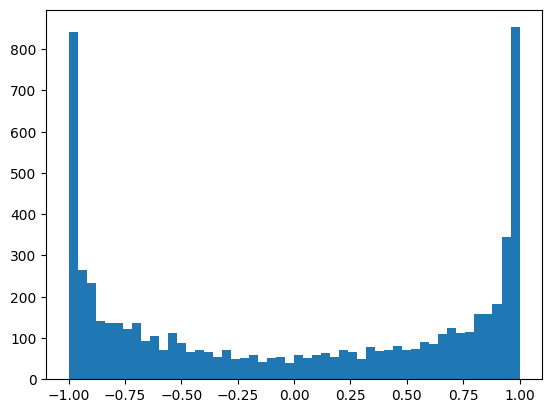

In [128]:
plt.hist(inner_layer.view(-1).tolist(), bins=50);

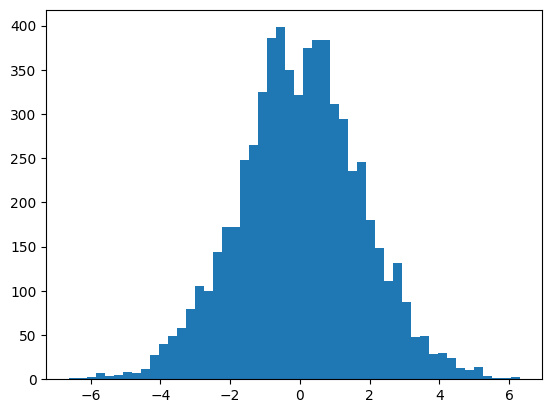

In [129]:
plt.hist(hpreact.view(-1).tolist(), bins=50);

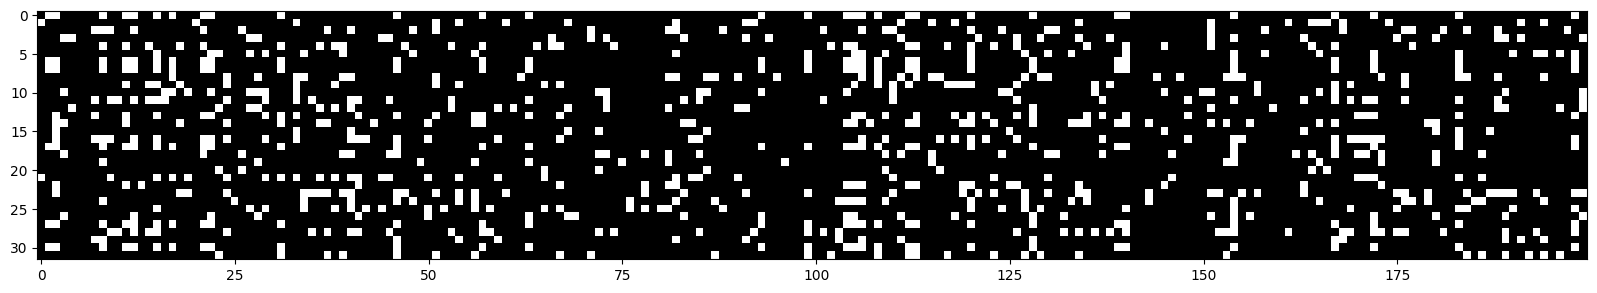

In [130]:
plt.figure(figsize=(20,10))
plt.imshow(inner_layer.abs()>0.99, cmap="gray");

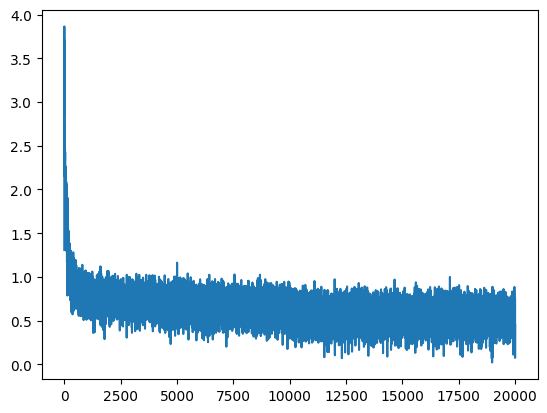

In [59]:
plt.plot(list(range(len(ls))), np.log(ls));

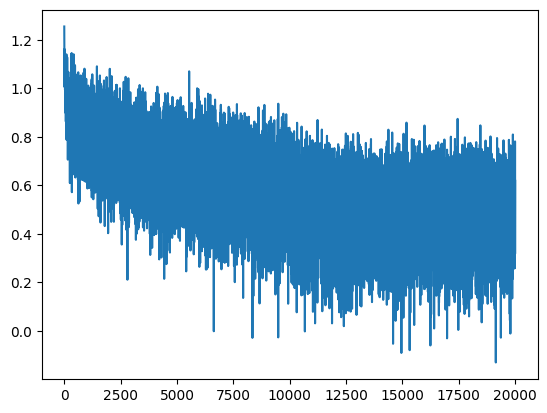

In [115]:
plt.plot(list(range(len(ls))), np.log(ls));

# Модель с batch-нормализацией

In [145]:
# MLP revisited
emb_d = 12
n_tokens = 3
inner_d = 200
C = torch.randn([vocab_size, emb_d])
W1 = torch.randn([n_tokens * emb_d, inner_d]) * (5/3) / ((n_tokens * emb_d)**0.5)
#B1 = torch.rand(inner_d) * 0.01
W2 = torch.randn([inner_d, vocab_size]) * 0.01
B2 = torch.randn(vocab_size) * 0

# BatchNorm parameters
bngain = torch.ones((1, inner_d))
bnbias = torch.zeros((1, inner_d))
bnmean_running = torch.zeros((1, inner_d))
bnstd_running = torch.ones((1, inner_d))

#parameters = [C, W1, W2, B1, B2]
parameters = [C, W1, W2, B2, bngain, bnbias]
for p in parameters:
  p.requires_grad = True

sum(p.nelement() for p in parameters) # number of parameters in total/

14842

In [146]:
ls = []
lsdev = []
for i in range(20000):
    idx = torch.randint(0, Xtr.shape[0], (32,))
    Xb, Yb = Xtr[idx], Ytr[idx]
    
    Xemb = F.one_hot(Xb, num_classes = vocab_size).float() @ C
    
    #inner_layer = (Xemb.view(Xemb.shape[0], -1) @ W1 + B1).relu()
    hpreact = Xemb.view(Xemb.shape[0], -1) @ W1 # + B1

    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    
    #hpreact = hpreact - bnmeani / bnstdi  

    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias  

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    inner_layer = hpreact.tanh()
    
    logits = inner_layer @ W2 + B2
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 10000 else 0.01
    
    for p in parameters:
        p.data -= lr * p.grad

    if i % 1000 == 0:

        Xemb = F.one_hot(Xdev, num_classes = vocab_size).float() @ C
        #inner_layer = (Xemb.view(Xemb.shape[0], -1) @ W1 + B1).relu()
        hpreact = Xemb.view(Xemb.shape[0], -1) @ W1 + B1
        #hpreact = (hpreact - bnmean_running) / bnstd_running 
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias 
        inner_layer = hpreact.relu()
        logits = inner_layer @ W2 + B2
        lossd = F.cross_entropy(logits, Ydev)

        
        print(f"{i}: Loss train {loss.item():.4f} loss dev {lossd.item():.4f}")

    ls.append(loss.item())
    # print(loss.item())
    # break

0: Loss train 3.5121 loss dev 3.4689
1000: Loss train 2.2709 loss dev 2.5252
2000: Loss train 2.3611 loss dev 2.5689
3000: Loss train 2.4576 loss dev 2.6974
4000: Loss train 2.2769 loss dev 2.8339
5000: Loss train 2.0570 loss dev 3.0170
6000: Loss train 2.0088 loss dev 3.0836
7000: Loss train 1.8561 loss dev 3.2832
8000: Loss train 2.2543 loss dev 3.3993
9000: Loss train 2.1574 loss dev 3.6478
10000: Loss train 1.5429 loss dev 3.6601
11000: Loss train 1.6460 loss dev 3.6586
12000: Loss train 1.9632 loss dev 3.7054
13000: Loss train 1.5544 loss dev 3.7214
14000: Loss train 1.4728 loss dev 3.7381
15000: Loss train 1.8404 loss dev 3.7881
16000: Loss train 1.6376 loss dev 3.7816
17000: Loss train 2.0515 loss dev 3.8140
18000: Loss train 1.7462 loss dev 3.8402
19000: Loss train 1.7275 loss dev 3.8702


In [ ]:
0: Loss train 3.5492 loss dev 3.5083
1000: Loss train 2.1241 loss dev 2.6438
2000: Loss train 2.0058 loss dev 2.8063
3000: Loss train 1.8247 loss dev 2.9344
4000: Loss train 2.0404 loss dev 3.1126
5000: Loss train 2.0444 loss dev 3.2930
6000: Loss train 1.9345 loss dev 3.3928
7000: Loss train 1.8708 loss dev 3.5426
8000: Loss train 1.6877 loss dev 3.5704
9000: Loss train 2.0284 loss dev 3.7282
10000: Loss train 1.9118 loss dev 3.8625
11000: Loss train 1.9307 loss dev 3.7406
12000: Loss train 1.5703 loss dev 3.7519
13000: Loss train 1.8008 loss dev 3.7597
14000: Loss train 1.6693 loss dev 3.7874
15000: Loss train 1.8036 loss dev 3.8146
16000: Loss train 1.7601 loss dev 3.8218
17000: Loss train 1.5557 loss dev 3.8215
18000: Loss train 1.5881 loss dev 3.8715
19000: Loss train 1.4929 loss dev 3.8926

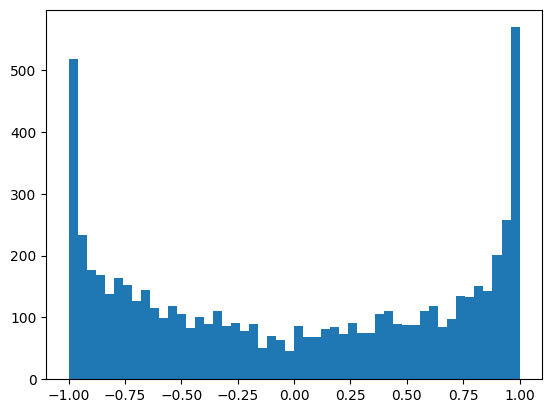

In [147]:
plt.hist(inner_layer.view(-1).tolist(), bins=50);

## Generate output

In [144]:
for _ in range(10):
    w = []
    X = [0]*3
    while(True):
        Xemb = F.one_hot(torch.tensor([X]), num_classes = vocab_size).float() @ C
        #inner_layer = (Xemb.view(Xemb.shape[0], -1) @ W1 + B1).relu()
        hpreact = Xemb.view(Xemb.shape[0], -1) @ W1 + B1
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias 
        inner_layer = hpreact.relu()
        logits = inner_layer @ W2 + B2
        probs = F.softmax(logits, dim=1)
        new_token = torch.multinomial(probs, 1).item()
        
        X = X+[new_token]
        X = X[1:]
    
        if new_token == 0:
            break
        
        w.append(new_token)
    print("".join([untokenize(ww) for ww in w]))

кетегхер
хлохокт
коб
голт
веоф
гул
ебутизгол
елан
юльхгуопогтиг-
глат


# PYTORCHIFYING -----------

In [232]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) #/ fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

class Relu:
    def __call__(self, x):
        self.out = torch.relu(x)
        return self.out
    def parameters(self):
        return []

In [233]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility
block_size = 3

In [204]:
C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

In [238]:
C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

In [239]:
with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1 # 5/3

In [240]:
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47808


In [245]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
  #break
  if i >= 1000:
      break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.5231


layer 2 (      Tanh): mean +0.00, std 0.64, saturated: 2.12%
layer 5 (      Tanh): mean +0.01, std 0.64, saturated: 2.50%
layer 8 (      Tanh): mean +0.00, std 0.64, saturated: 2.34%
layer 11 (      Tanh): mean +0.01, std 0.64, saturated: 2.12%
layer 14 (      Tanh): mean +0.00, std 0.64, saturated: 2.00%


Text(0.5, 1.0, 'activation distribution')

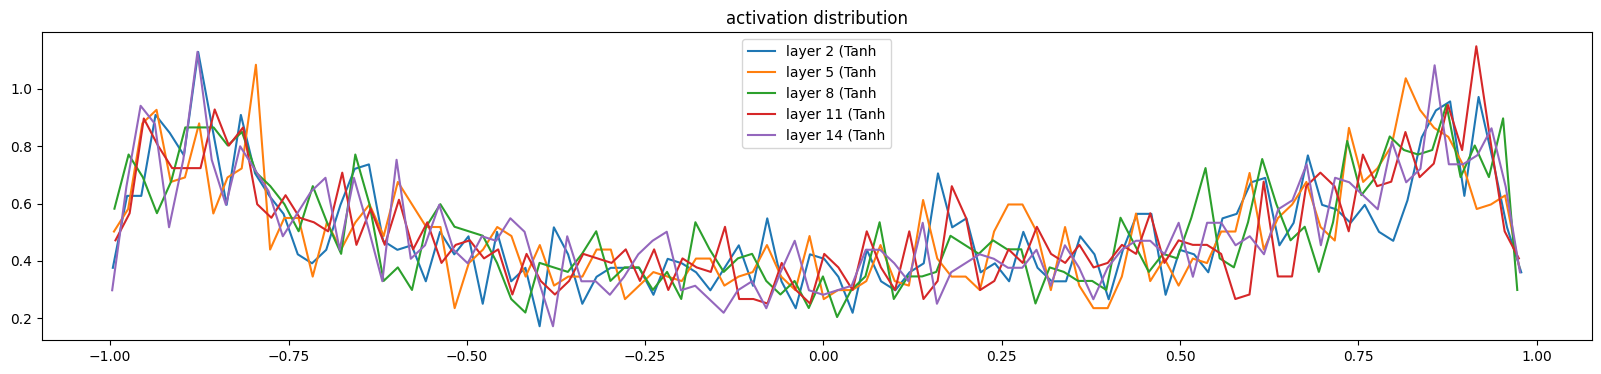

In [246]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.931733e-03
layer 5 (      Tanh): mean +0.000000, std 3.763867e-03
layer 8 (      Tanh): mean +0.000000, std 3.432894e-03
layer 11 (      Tanh): mean -0.000000, std 3.270265e-03
layer 14 (      Tanh): mean +0.000000, std 2.957088e-03


Text(0.5, 1.0, 'gradient distribution')

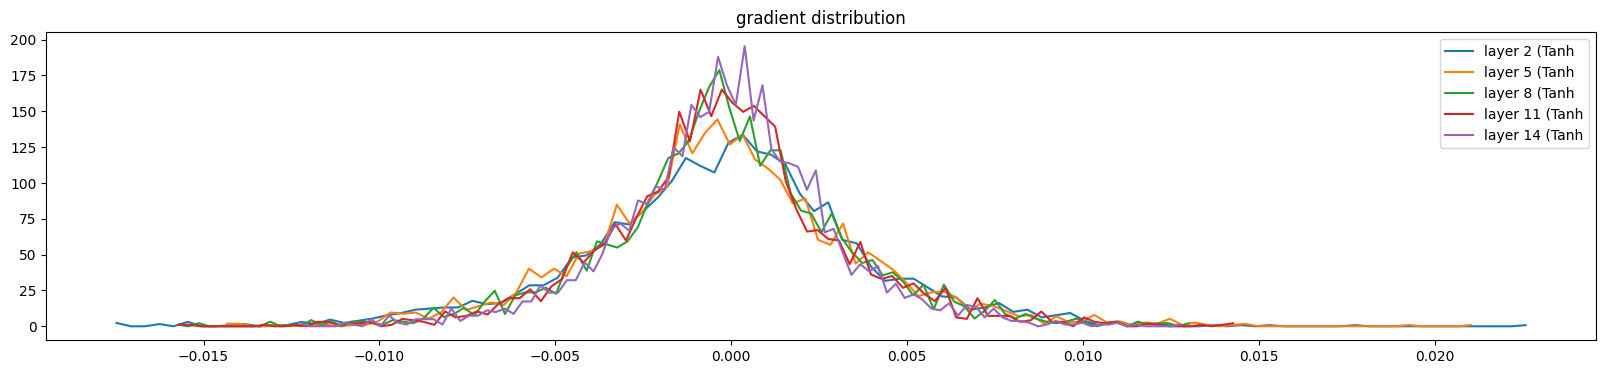

In [247]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (34, 10) | mean -0.000000 | std 6.683981e-03 | grad:data ratio 6.713929e-03
weight  (30, 100) | mean +0.000010 | std 3.095267e-03 | grad:data ratio 3.085241e-03
weight (100, 100) | mean +0.000018 | std 1.421802e-03 | grad:data ratio 1.415266e-03
weight (100, 100) | mean +0.000008 | std 1.386236e-03 | grad:data ratio 1.387500e-03
weight (100, 100) | mean +0.000006 | std 1.208326e-03 | grad:data ratio 1.202076e-03
weight (100, 100) | mean -0.000015 | std 1.151241e-03 | grad:data ratio 1.148466e-03
weight  (100, 34) | mean +0.000014 | std 1.800882e-03 | grad:data ratio 1.791698e-03


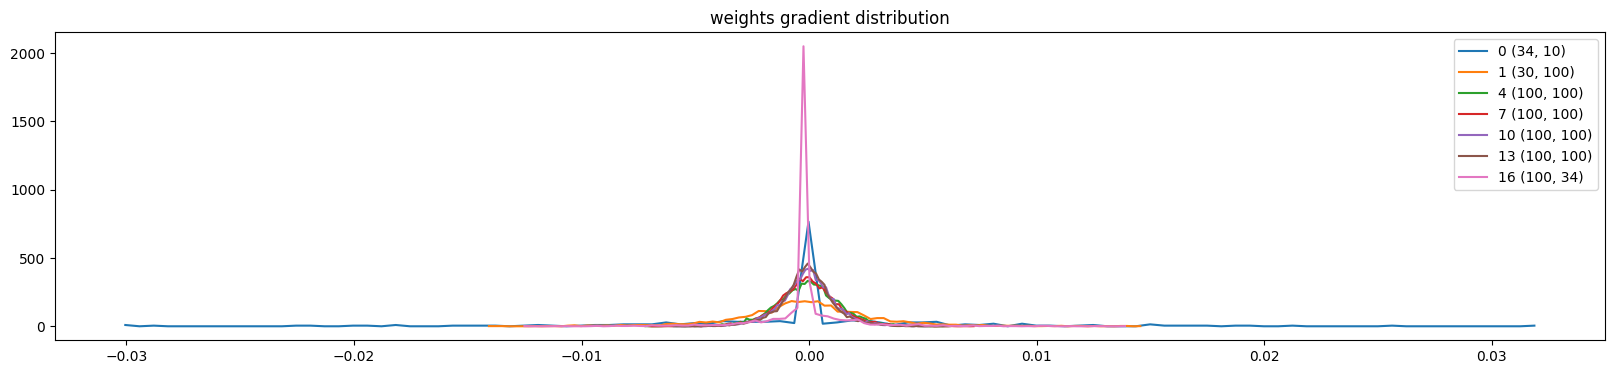

In [248]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

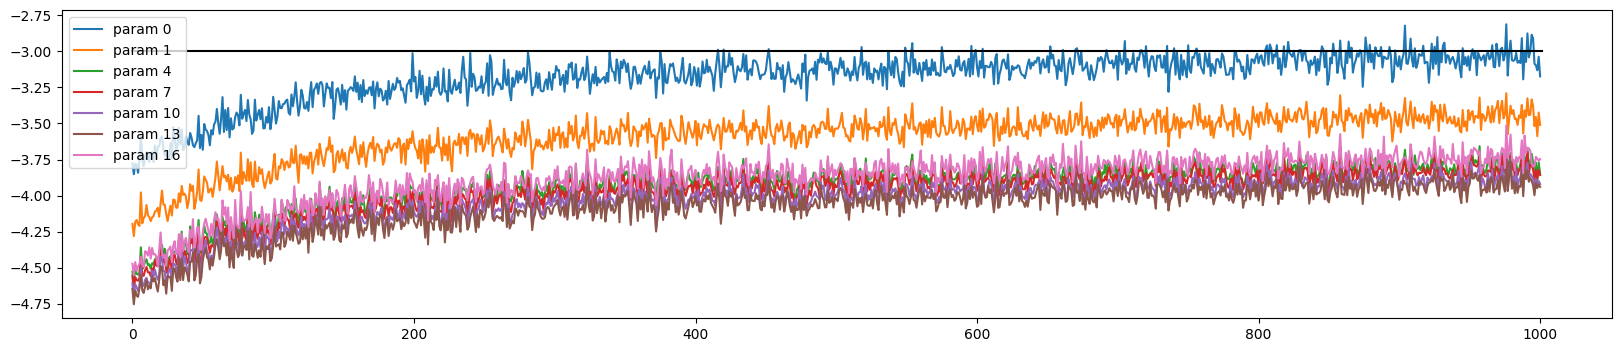

In [249]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
